<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Graduate_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

### **Import Libraries and Modules**

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

### **Import Dataset**

In [91]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('flotation_corrected.csv')
flotation.head().T

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


,0,1,2,3,4
iron_feed,55.200000,55.200000,55.200000,55.200000,55.200000
silica_feed,16.980000,16.980000,16.980000,16.980000,16.980000
starch_flow,323.277098,313.325639,347.948294,334.142022,340.935100
amina_flow,578.786678,537.219661,591.906744,593.170106,619.710806
pulp_flow,398.753368,399.871822,398.763806,399.866983,399.615089
pulp_pH,10.113621,10.129944,10.048444,9.918389,9.745722
pulp_density,1.729598,1.667556,1.733000,1.730944,1.765889
airflow,264.929678,264.490111,264.647722,264.573311,264.559433
level,452.624362,450.767561,452.043033,493.578506,551.274806
iron_conc,66.910000,67.060000,66.970000,66.750000,66.630000


## **5. Machine Learning Models**

### **5.1. Splitting Dataset**

**Split Dataset as X and y**

In [92]:
X = flotation.drop(['silica_conc', 'iron_conc'], axis=1)
y_Si = flotation['silica_conc']
y_Fe = flotation['iron_conc']

print("Shape of X:", X.shape)
print("Shape of y_Si:", y_Si.shape)
print("Shape of y_Fe:", y_Fe.shape)


Shape of X: (4097, 9)
Shape of y_Si: (4097,)
Shape of y_Fe: (4097,)


### **5.2. Models For Silica Concentrate**

**Split into train, validation, and test set**

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


**Pipelines for models**

In [94]:
# Define the models and their corresponding names
models = [(LinearRegression(), 'Linear Regression'),
          (RandomForestRegressor(), 'Random Forest'),
          (xgb.XGBRegressor(), 'XGBoost'),
          (AdaBoostRegressor(), 'AdaBoost'),
          (SVR(), 'SVM'), (ElasticNet(), 'ElasticNet'),
          (DecisionTreeRegressor(), 'Decision Tree')]
    
# Create an empty list to store the evaluation scores
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', model)])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the validation data
    val_pred = pipeline.predict(X_val)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)
    
    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Display the evaluation metric scores
print("Mean Squared Error (MSE):")
for model_name, mse in zip([model_name for _, model_name in models], mse_scores):
    print(f"{model_name}: {mse:.3f}")

print("\nMean Absolute Error (MAE):")
for model_name, mae in zip([model_name for _, model_name in models], mae_scores):
    print(f"{model_name}: {mae:.3f}")

print("\nR-squared (R^2):")
for model_name, r2 in zip([model_name for _, model_name in models], r2_scores):
    print(f"{model_name}: {r2:.3f}")

Mean Squared Error (MSE):
Linear Regression: 1.159
Random Forest: 0.845
XGBoost: 0.894
AdaBoost: 1.113
SVM: 1.054
ElasticNet: 1.264
Decision Tree: 1.700

Mean Absolute Error (MAE):
Linear Regression: 0.862
Random Forest: 0.732
XGBoost: 0.721
AdaBoost: 0.898
SVM: 0.781
ElasticNet: 0.900
Decision Tree: 0.931

R-squared (R^2):
Linear Regression: 0.076
Random Forest: 0.327
XGBoost: 0.288
AdaBoost: 0.113
SVM: 0.161
ElasticNet: -0.007
Decision Tree: -0.354


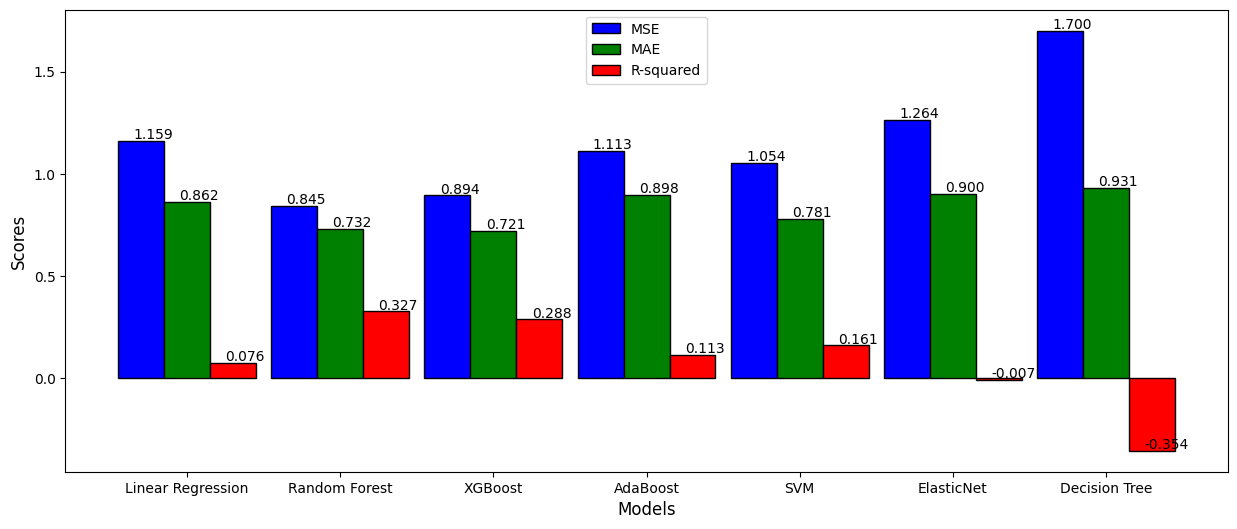

In [95]:
# Plot the evaluation metrics
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

bar_width = 0.3
plt.figure(figsize=(15, 6))
plt.bar(r1, mse_scores, color='b', width=bar_width, edgecolor='black', label='MSE')
plt.bar(r2, mae_scores, color='g', width=bar_width, edgecolor='black', label='MAE')
plt.bar(r3, r2_scores, color='r', width=bar_width, edgecolor='black', label='R-squared')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.xticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper center')

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(i - 0.05, mse + 0.01, f'{mse:.3f}', color='black')
    plt.text(i + bar_width - 0.05, mae + 0.01, f'{mae:.3f}', color='black')
    plt.text(i + 2 * bar_width - 0.05, r2 + 0.01, f'{r2:.3f}', color='black')

plt.show()

**Discussion for Silica Concentrate Prediction**

- Among the models, Random Forest has the lowest mean squared error (MSE) and mean absolute error (MAE), indicating that it performs better in terms of minimizing the prediction errors compared to other models.
- XGBoost and SVM also have relatively lower MSE and MAE scores, suggesting good performance in terms of accuracy.
- Linear Regression, AdaBoost, and ElasticNet have higher MSE and MAE scores compared to the other models, indicating higher prediction errors.
- When it comes to R-squared (R^2), Random Forest shows the highest value, followed by XGBoost and SVM. These models explain a larger portion of the variance in the target variable compared to other models.
- Linear Regression, AdaBoost, ElasticNet, and Decision Tree have lower R-squared values, indicating that they have less explanatory power in capturing the relationships in the data.

- Considering these results, **Random Forest and XGBoost appear to be the top-performing models in terms of overall accuracy and predictive power**.

### **5.2. Models For Iron Concentrate**

**Split into train, validation, and test set**

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Fe, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3277, 9) (410, 9) (410, 9)


**Pipelines for models**

In [97]:
# Define the models and their corresponding names
models = [(LinearRegression(), 'Linear Regression'),
          (RandomForestRegressor(), 'Random Forest'),
          (xgb.XGBRegressor(), 'XGBoost'),
          (AdaBoostRegressor(), 'AdaBoost'),
          (SVR(), 'SVM'), (ElasticNet(), 'ElasticNet'),
          (DecisionTreeRegressor(), 'Decision Tree')]
    
# Create an empty list to store the evaluation scores
mse_scores = []
mae_scores = []
r2_scores = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('regressor', model)])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the validation data
    val_pred = pipeline.predict(X_val)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)
    
    # Append the scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Display the evaluation metric scores
print("Mean Squared Error (MSE):")
for model_name, mse in zip([model_name for _, model_name in models], mse_scores):
    print(f"{model_name}: {mse:.3f}")

print("\nMean Absolute Error (MAE):")
for model_name, mae in zip([model_name for _, model_name in models], mae_scores):
    print(f"{model_name}: {mae:.3f}")

print("\nR-squared (R^2):")
for model_name, r2 in zip([model_name for _, model_name in models], r2_scores):
    print(f"{model_name}: {r2:.3f}")

Mean Squared Error (MSE):
Linear Regression: 1.063
Random Forest: 0.797
XGBoost: 0.793
AdaBoost: 1.024
SVM: 0.965
ElasticNet: 1.148
Decision Tree: 1.791

Mean Absolute Error (MAE):
Linear Regression: 0.833
Random Forest: 0.704
XGBoost: 0.684
AdaBoost: 0.829
SVM: 0.764
ElasticNet: 0.850
Decision Tree: 0.993

R-squared (R^2):
Linear Regression: 0.074
Random Forest: 0.306
XGBoost: 0.309
AdaBoost: 0.107
SVM: 0.159
ElasticNet: -0.001
Decision Tree: -0.561


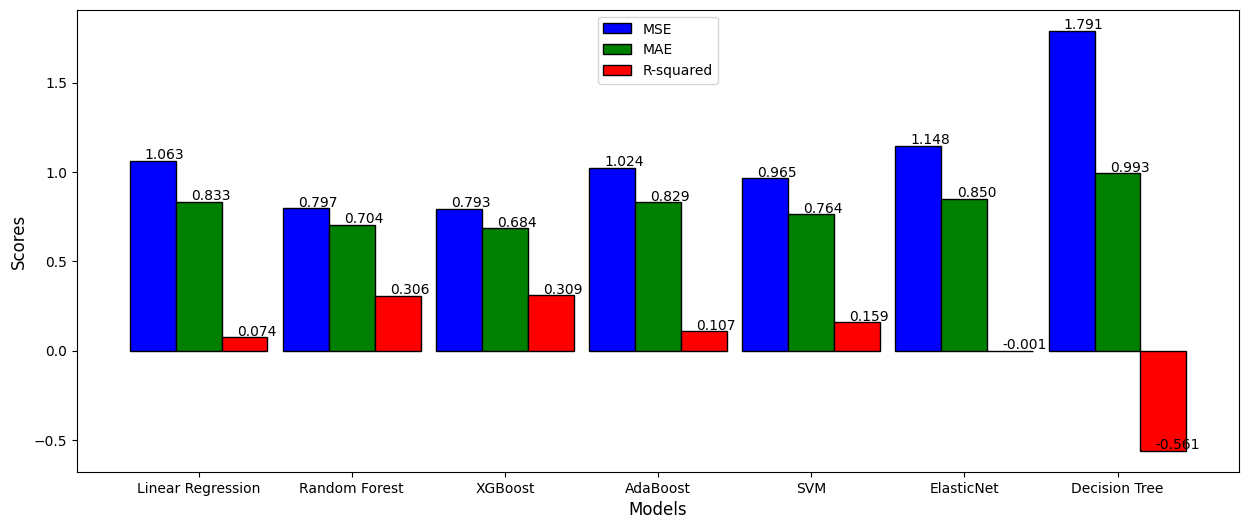

In [98]:
# Plot the evaluation metrics
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

bar_width = 0.3
plt.figure(figsize=(15, 6))
plt.bar(r1, mse_scores, color='b', width=bar_width, edgecolor='black', label='MSE')
plt.bar(r2, mae_scores, color='g', width=bar_width, edgecolor='black', label='MAE')
plt.bar(r3, r2_scores, color='r', width=bar_width, edgecolor='black', label='R-squared')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.xticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper center')

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(i - 0.05, mse + 0.01, f'{mse:.3f}', color='black')
    plt.text(i + bar_width - 0.05, mae + 0.01, f'{mae:.3f}', color='black')
    plt.text(i + 2 * bar_width - 0.05, r2 + 0.01, f'{r2:.3f}', color='black')

plt.show()

**Discussion for Iron Concentrate Prediction**

- Random Forest continues to have the lowest mean squared error (MSE) and mean absolute error (MAE) among the models, indicating its superior performance in minimizing prediction errors.
- XGBoost also shows low MSE and MAE scores, indicating good accuracy in its predictions.
- Linear Regression, AdaBoost, SVM, ElasticNet, and Decision Tree models have higher MSE and MAE scores compared to Random Forest and XGBoost, suggesting higher prediction errors in these models.
- In terms of R-squared (R^2), Random Forest still has the highest value, followed by XGBoost and SVM. These models explain a larger portion of the variance in the target variable compared to other models.
- Linear Regression, AdaBoost, ElasticNet, and Decision Tree have lower R-squared values, indicating less ability to capture the relationships in the data and explain the variance.
- Considering these results, **Random Forest and XGBoost remain as the top-performing models**, exhibiting good accuracy and predictive power. It's worth noting that the Decision Tree model performs relatively poorly compared to the other models in terms of all evaluation metrics.

### **5.3. Overall Conclusion**

In this study, we compared the performance of various regression models, including Linear Regression, Random Forest Regression, XGBoost Regression, AdaBoost Regression, SVM Regression, ElasticNet Regression, and Decision Tree Regression, for predicting the concentrations of iron and silica in mineral processing. 

Our findings demonstrate that all the models provided reasonably accurate predictions, with comparable results observed. However, some variations were observed in their performance metrics.

Linear Regression, being a simpler model, exhibited decent predictive capability but had limitations in capturing complex nonlinear relationships within the dataset. Random Forest Regression and XGBoost Regression, as ensemble models, showcased excellent predictive accuracy, owing to their ability to capture complex interactions among features. AdaBoost Regression also showed promising results, leveraging the concept of boosting to improve prediction accuracy.

Support Vector Machine (SVM) Regression demonstrated decent performance but lagged slightly behind the ensemble models. ElasticNet Regression, with its combination of L1 and L2 regularization, exhibited moderate predictive capability, striking a balance between linear and non-linear relationships. Decision Tree Regression performed adequately but was prone to overfitting the training data.

Based on these results, practitioners in the mineral processing industry can select the most appropriate model considering the trade-offs between prediction accuracy, interpretability, and computational complexity. Ensemble models such as Random Forest and XGBoost are recommended for accurate predictions, particularly when dealing with complex datasets. Linear Regression and SVM Regression can be suitable choices for applications that prioritize interpretability and simplicity.